<img src="https://raw.githubusercontent.com/quantumlib/Cirq/master/docs/_static/Cirq_logo_color.png"  height="80px"/>  [Thank you for the feedback!](https://forms.gle/oTG7xaT8zyq5svN88)

[Cirq](https://github.com/quantumlib/cirq) is a framework for writing quantum algorithms for noisy intermediate scale quantum (NISQ) devices. 

Roughly speaking, NISQ devices are those with O(100) qubits that can enact O(1000) gates.  Because the resources for NISQ devices are so constrained, we believe that a framework for writing programs on these devices needs to be aware of all of the architectural properties of the device on which the algorithm is written. This is in contrast to other frameworks where there is a clean separation between the abstract model being used and the details of the device.  

# The (Python) Basics

In this tutorial, you will learn the basics of writing quantum algorithms in Cirq. First, a very brief intro to some Python.

**Instructions**: Go to File --> Save Copy in Drive to get your own copy to play with.

>[The (Python) Basics](#scrollTo=8_LTWlMtzqh9)

>>[Iterators](#scrollTo=rPgPbry6-mF3)

>>[Generators](#scrollTo=8V1v8TVTeE0W)

>>[Decorators and @property](#scrollTo=FIlAUD85v_cn)

>[The Cirq Basics](#scrollTo=hgDjfotpadSY)

>>[Qubits, Moments, Operations, and Circuits](#scrollTo=8A7a3jcql1l5)

>>[Create a Circuit](#scrollTo=VFwmWPf7D057)

>>[Building Circuits](#scrollTo=uaDb6B_jPgrb)

>>[Exercise: Create a circuit](#scrollTo=y9conKPAPn26)

>>>[Solution](#scrollTo=KnA4uBkwEw5-)

>>[Gates](#scrollTo=mmhbPIhT4YAI)

>>[Custom Gate Implementation](#scrollTo=RACz4Z5GDMAf)

>>[Exercise: Custom Controlled Rx gate](#scrollTo=y63aDja8R4rc)

>>>[Problem Statement](#scrollTo=AmVXlCo7n5Yj)

>>>[Solution](#scrollTo=7SoneHQRGeUW)

>>[Gate decompositions](#scrollTo=9W_Vlgpzz0D1)

>[Google's Xmon Gates](#scrollTo=gM1ZW7TstvK9)

>[Simulations of a Circuit](#scrollTo=X15yPl_KQ20Z)

>>[Repetitions](#scrollTo=YLpiz0aN1Jd6)

>[Parameterized Circuits](#scrollTo=3HtlMxa6QpVo)

>>[Exercise: Rotate a qubit](#scrollTo=r-CjbPwkRI_I)

>>>[Solution](#scrollTo=hGTFY6hM3CBi)

>[Noise](#scrollTo=FEM73JPALREa)

>>[Monte Carlo Simulations](#scrollTo=3qUM-Kpi8Iy4)

>>[Adding Noise to Circuits and Simulations](#scrollTo=weWPzaPx8zly)

>[Compiling / Optimizing](#scrollTo=J9ia4eatUQ_x)

>>[Exercise: Simplify flipped CNOTs](#scrollTo=--aUfkiaUb3S)

>>>[Solution:](#scrollTo=VqltCQJIVgxg)

>[Devices](#scrollTo=PvJCA3e0QsuI)

>>[Exercise: Make a Device](#scrollTo=lyFcloaARXg4)

>>>[Solution](#scrollTo=Qx1iaMysIfVj)

>[Other interesting things in Cirq](#scrollTo=tMC-nLE474nH)

>>[Experiments](#scrollTo=tMC-nLE474nH)

>>[Testing](#scrollTo=38c8tWcX90Zn)

>>[Export](#scrollTo=iYqy0qwU9sZy)

>>[Quirk](#scrollTo=QlgFtRQs-TfQ)



---
## Iterators


Iterators are a core functionality of Python: for example, when for loops are executed. An object is called *iterable* if an iterator can be generated from that object.

The advantage of using iterators is that they could be used to save resources: for example, no need to store data in system memory.

In [ ]:
# # define a list
the_list = ['a', 'b', 'c', 'd', 2, 0, 1, 9]

print("Hello list!", the_list)

# get an iterator using iter()
the_iter = iter(the_list)

print ("first element is printed manually")
print(next(the_iter))

print("and the other in a for loop")

for x in the_iter:
  print(x)

Hello list! ['a', 'b', 'c', 'd', 2, 0, 1, 9]
first element is printed manually
a
and the other in a for loop
b
c
d
2
0
1
9


Python iterators **cannot be reseted**. In fact an iterator is a class that implements two methods: `__iter__()` and `__next__()`. The first method returns the iterator object itself, and `__next__` generates (or returns from memory) the following element. Note that there are also infinite iterators (!).



In [ ]:
class TheCirqBootcampIterator:
  def __init__(self, list):
    # the constructor
    self.max = len(list)
    self.list = list
    
  def __iter__(self):
    # iter can be used for initialization
    self.position = self.max
    return self
  
  def __next__(self):
    # ... and the iterator is advanced
    if self.position > 0:
      self.position -= 1
      return "*" + str(self.list[self.position])
  
    # this is a builtin exception, and the for loop "catches" it
    # to know when iteration finished
    raise StopIteration
    
    
the_iterator = TheCirqBootcampIterator(the_list)

print(the_iterator)

for x in the_iterator:
  print(x)    

*9
*1
*0
*2
*d
*c
*b
*a


## Generators

are a way of letting Python handle the complications of constructing and managing the internal state of the iterator. A generator is a function that returns an object which can be iterated over (one value at a time). Instead of explicitly creating the iterator, the `yield` keyword is used. 

More simple (and inexact) explanation: In a function, whenever `yield` is used, the execution is paused, the function state is saved, and later successive calls continue from the saved state. Compare this with `return`, which terminates the function entirely.

**Context**: For the example of Cirq, imagine that quantum circuit sub-routines can be implemented using generators.

**Note**: The yield keyword can be used in more complicated Python constructs called [coroutines](http://dabeaz.com/coroutines/Coroutines.pdf), which will not be discussed here.

In [ ]:
def the_bootcamp_generator(the_list):
  max_len = len(the_list)
  
  for i in range(1, max_len +1):
    yield the_list[max_len - i]
    
  return

the_generator = the_bootcamp_generator(the_list)

print(the_generator)

# and we can iterate over the generator
for x in the_generator:
  print(x)
  

<generator object the_bootcamp_generator at 0x7f18dd63a5c8>
9
1
0
2
d
c
b
a


## Decorators and @property

Imagine a function which you want to wrap with another function (i.e. define a function inside another function). For example, print something before and after an *arbitrary* function was called. Functions are first-order objects in Python (and *everything* is an object in Python).

**Context**: Many Cirq classes use the `property` decorator (e.g. see [`XPowGate.phase_exponent`](https://cirq.readthedocs.io/en/stable/generated/cirq.XPowGate.phase_exponent.html)).

In [ ]:
def wrap_a_function_between_prints(function_to_wrap):
  def wrapped_function(*args, **kwargs):
    print("using red wrapping paper")
    function_to_wrap(*args, **kwargs)
    print("using a green ribbon")
  return wrapped_function

print("first")
w = wrap_a_function_between_prints(print)

w("the gift")

first
using red wrapping paper
the gift
using a green ribbon


The `wrapped_function` is a new object (function) which calls an existing function. This can be made more easy, like in the following example.

In [ ]:
# use the wrapper with an @ symbol before the function definition
@wrap_a_function_between_prints
def hello_world():
  print("Hello World!")
  return
  
print("second")
hello_world()

second
using red wrapping paper
Hello World!
using a green ribbon


Having said this, imagine that a circuit `num_qubits` field, and it has to be ensured that the number of qubits is always larger than 1.

In [ ]:
class TheQuantumCircuit:
  def __init__(self):
    self.nr_qubits = 1

circ = TheQuantumCircuit()
circ.nr_qubits = -1

assert(circ.nr_qubits > 0)

AssertionError: ignored

The issue is that the programmer was able to change the value of num_qubits and set a value which was not allowed (negative integer). This could be solved by writing a setter method and calling it.

In [ ]:
class TheQuantumCircuit:
  def __init__(self):
    self.nr_qubits = 1
    
  def set_nr_qubits(self, val):
    if val > 0:
      self.nr_qubits = val
      print("updated nr_qubits to {}".format(val))

circ2 = TheQuantumCircuit()
# will not update
circ2.set_nr_qubits(-1)
# will update
circ2.set_nr_qubits(100)

# somebody still use legacy code and can break it easily
circ2.nr_qubits = -1
assert(circ2.nr_qubits > 0)

updated nr_qubits to 100


AssertionError: ignored

However, it is not guaranteed that the qubit number check will be automatically used everywhere (imagine larger experiment code base), where the field was used. The solution is to decorate the `nr_qubits` as a *property*.

In [ ]:
class TheQuantumCircuit:
  def __init__(self):
    # notice that here the field name starts with a underscore
    self._nr_qubits = 1
    
  @property
  def nr_qubits(self):
    return self._nr_qubits
  
  @nr_qubits.setter  
  def nr_qubits(self, val):
    if val > 0:
      self._nr_qubits = val
      print("updated nr_qubits to {}".format(val))

circ3 = TheQuantumCircuit()

circ3.nr_qubits = -1
assert(circ3._nr_qubits > 0)
print("qubits", circ3.nr_qubits)

qubits 1


# The Cirq Basics

In the following some of the Cirq basics are introduced and exemplified.

**Note:** Be aware that Cirq is still alpha software, meaning **we are still making breaking changes all the time**. If you don't want your project to suddenly go from working to not working when we release a new version, you should depend on a *specific version* of Cirq and periodically bump that version to the latest one. For the purposes of this tutorial, we will use version of `0.5` (i.e. `cirq==0.5` in pip's version notation).

In [ ]:
# install latest version
!pip install cirq==0.6 --quiet

# Alternatively, install directly from HEAD on github:
# !pip install git+https://github.com/quantumlib/Cirq.git --quiet

     |████████████████████████████████| 1.2MB 4.9MB/s 
     |████████████████████████████████| 1.2MB 55.7MB/s 
     |████████████████████████████████| 1.8MB 45.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


(Note: you may see an error about `albumentations` requiring an old `imgaug`. You can ignore this error.)

Let's check that Cirq has been successfully installed by importing Cirq and priting out a diagram of the Google's Bristlecone device. ![Google's Bristecone chip](https://4.bp.blogspot.com/-b9akad6ismU/WpmyaJo-cYI/AAAAAAAACa8/mCqPBJxv5oUivy6Jq42FSOQYkeRlTmkiwCLcBGAs/s1600/image1.png)

In [ ]:
import cirq
import numpy as np
import matplotlib as plt
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

The import ran without raising an error, and the output is in fact the grid of qubits for the Bristlecone device. Looks like the install worked!



---

## Qubits, Moments, Operations, and Circuits
 
 In Cirq, circuits are represented either by a `Circuit` object or a `Schedule` object. `Schedule`s offer more control over quantum gates and circuits at the timing level.

A **`Circuit`** is a collection of `Moment`s. 

A **`Moment`** is a collection of `Operation`s that all act during the same abstract time slice. 

An **`Operation`** is a an effect that operates on a specific subset of Qubits. The most common type of `Operation` is a `Gate` applied to several qubits (a "`GateOperation`"). The following diagram should help illustrate these concepts.

![Circuits, Moments, and Operations.](https://cirq.readthedocs.io/en/latest/_images/CircuitMomentOperation.png)

## Create a Circuit

Let's create a `Circuit`.  Note that in the previous cell we imported cirq, so we will assume that cirq has been imported through out the rest of this notebook.

In [ ]:
# These are three qubits
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

# This is a collection of operations
# Each operation is a gate
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b, c), cirq.H(b)]

# The circuit is constructed from the collection of operations
circuit = cirq.Circuit(ops)

# Let us have a look...
print(circuit)

a: ───H───────────

b: ───H───@───H───
          │
c: ───────X───────


We can unpack this a bit and see all of the components for the circuit.


The first thing we do is pick some qubits to use. There are many different types of qubits in Cirq, and you can define your own by inheriting from the [`cirq.Qid`](https://cirq.readthedocs.io/en/stable/generated/cirq.Qid.html) class. There's nothing inherently special or magical about these quantum id types such as [`cirq.NamedQubit`](https://cirq.readthedocs.io/en/stable/generated/cirq.NamedQubit.html). They simply identify what you wish to operate on, which is relevant when you are targeting a specific device.

**Example**: if we were creating a circuit for the Bristlecone device we would use `cirq.GridQubit(5, 0)` to refer to the qubit in the left most position of the device.

To keep these simple for now, we'll start with abstract qubits simply identified by a name such as "a".
```
a = cirq.NamedQubit("a")
```

Next we encounter of the object [`cirq.H`](https://cirq.readthedocs.io/en/stable/generated/cirq.H.html), which is a Hadamard gate.  `cirq.H` is an instance of the `cirq.HGate` class, which itself is a subclass of [`Gate`](https://cirq.readthedocs.io/en/stable/generated/cirq.Gate.html) (along with other classes). 
$$H = {1 \over \sqrt{2}} \left[ \begin{array}[cc]  & 1 & 1  \\ 1 & -1 \end{array}\right]$$
We can use [cirq.unitary](https://cirq.readthedocs.io/en/stable/generated/cirq.unitary.html?highlight=cirq.unitary) to see this unitary matrix:

In [ ]:
cirq.unitary(cirq.H)

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

`Gate` objects have the ability to applied "on" to one or more qubits.  There are two ways to do this for gates, either using the `on` method or by directly calling the gate on the qubits as if the gate were a function and the qubits were arguments.  For example to apply the `H` onto qubit `a` we can say
```
cirq.H.on(a)
```
or 
```
cirq.H(a)
```

The result of those expressions is a [`GateOperation`](https://cirq.readthedocs.io/en/stable/generated/cirq.GateOperation.html) object, which is a type of [`Operation`](https://cirq.readthedocs.io/en/stable/generated/cirq.Operation.html).

In Cirq we make a strong distinction between `Operation`s and `Gate`s.
*   An `Operation` is associated with **specific qubits** and can be put in `Circuit`s.
*   A `Gate` has **unspecified qubits**, and will produce an operation when given qubits.


Once you have a collection of operations, you can construct a `Circuit` using the class method `Circuit(operations)` (more on that in a minute):
```
circuit = cirq.Circuit(ops)
```
The last thing we did in the example code was use the (surprisingly useful) ability to print the circuit as a text diagram.

The diagram is visually helpful, but it doesn't really get into the internal details of how the [`Circuit`](https://cirq.readthedocs.io/en/stable/generated/cirq.Circuit.html) is represented. 
A [`Circuit`](https://cirq.readthedocs.io/en/stable/generated/cirq.Circuit.html) is made up of a sequence of [`Moment`](https://cirq.readthedocs.io/en/stable/generated/cirq.Moment.html) objects.
And each `Moment` object is a list of non-overlapping  [`Operation`](https://cirq.readthedocs.io/en/stable/generated/cirq.Operation.html)s.
To see this internal structure, we can iterate over the `Moment`s in the `Circuit` while printing them out.

In [ ]:
# http://book.pythontips.com/en/latest/enumerate.html
# enumerate allows to loop over something and have an automatic counter (e.g. i)
for i, moment in enumerate(circuit):
    print('Moment {}: {}'.format(i, moment))

Moment 0: H(a) and H(b)
Moment 1: CNOT(b, c)
Moment 2: H(b)


We can also just print the circuit's `repr`, which returns a somewhat more detailed (if less readable) expression.

In [ ]:
print(repr(circuit))

cirq.Circuit([
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('a')),
        cirq.H.on(cirq.NamedQubit('b')),
    ]),
    cirq.Moment(operations=[
        cirq.CNOT.on(cirq.NamedQubit('b'), cirq.NamedQubit('c')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('b')),
    ]),
])


The usefulness of printing the `repr` is that it includes *all* the gory details.
These details can be useful when debugging.
The `repr` is also a valid python expression that evaluates to the circuit.
For example, if we notice that a circuit generated in some complicated way triggers a bug in a simulator, copy-pasting the generated circuit's `repr` into a test, and then working from there, is a simple way to decouple the reproduction of the bug from the circuit generation code.

## Building Circuits
There are many ways to construct and modify circuits, and each of these is useful in different contexts.  Here are a few examples:


1.  [ `Circuit(*ops)`](https://cirq.readthedocs.io/en/stable/generated/cirq.Circuit.html): This is the simplest way to make a circuit. Give this method some operations, and out pops a circuit.
2.  [`append`](https://cirq.readthedocs.io/en/stable/generated/cirq.Circuit.append.html):  `Circuit`s are mutable. You can start with an empty `c = cirq.Circuit()` and simply `c.append(operations)` to add on more and more operations 
3. [`insert`](https://cirq.readthedocs.io/en/stable/generated/cirq.Circuit.insert.html):  Instead of appending, you can insert before a particular moment location (labeled by an integer index)

Or a generator function that sometimes yields tuples of operations and other times yields individual operations.
Or just a single operation (without a list around it).
If it can recursively iterated into individual operations, `append` and `insert` will take it.

The main place where auto-flattening is useful is when you are generating a circuit's operations using [generator](https://realpython.com/introduction-to-python-generators/) functions. This is jumping a bit ahead of what we've explained, but basically auto-flattening means that generators producing operations for a circuit can simply `yield` sub-generators (instead of iterating over them and yielding their items).


**Note**: Generators in Python are functions that can be paused and resumed on the fly, returning an object that can be iterated over.  To create a generator, you define a function as you normally would but use the **yield statement instead of return**.



In [ ]:
# The quantum SWAP gate is a sequence of three CNOT gates
def xor_swap(a, b):
    yield cirq.CNOT(a, b)
    yield cirq.CNOT(b, a)
    yield cirq.CNOT(a, b)


def left_rotate(qubits):
    for i in range(len(qubits) - 1):
        a, b = qubits[i:i+2]
        yield xor_swap(a, b)

line = cirq.LineQubit.range(5)

print(cirq.Circuit(left_rotate(line)))

0: ───@───X───@───────────────────────────────────────
      │   │   │
1: ───X───@───X───@───X───@───────────────────────────
                  │   │   │
2: ───────────────X───@───X───@───X───@───────────────
                              │   │   │
3: ───────────────────────────X───@───X───@───X───@───
                                          │   │   │
4: ───────────────────────────────────────X───@───X───


You may have noticed that there is a hole in what we've explained so far. The output is a 2-dimensional circuit (a list-of-lists-of-operations).
There is a degree of freedom that hasn't been account for.
Specifically: how does cirq choose the moment that each operation will be placed within?

**[The answer is](https://cirq.readthedocs.io/en/stable/circuits.html?highlight=InsertStrategy)**: it depends on the  [`InsertStrategy` ](https://cirq.readthedocs.io/en/stable/generated/cirq.InsertStrategy.html)you choose.

There are currently four insertion strategies in Cirq:

1.  `InsertStrategy.EARLIEST` (currently the default)
2. `InsertStrategy.NEW`,
3. `InsertStrategy.INLINE`
4.  `InsertStrategy.NEW_THEN_INLINE` 

`InsertStrategy.EARLIEST` is defined as
> `InsertStrategy.EARLIEST`: Scans backward from the insert
> location until a moment with operations touching qubits affected by the
> operation to insert is found. The operation is added into the moment just
> after that location.

For example, if we first create an `Operation` in a single moment,
and then use `InsertStrategy.EARLIEST` the `Operation` can slide back to this
first `Moment` if there is space

An `InsertStrategy` defines how ``Operations`` are placed in a `Circuit` when requested to be inserted at a given location.
Here a `location` is identified by the index of the `Moment` in the `Circuit` that operations should be placed before (in the case of `Circuit.append` this means inserting at the index `len(circuit)`; which is one more than the largets moment index and so represents the end of the circuit).

In [ ]:
circuit = cirq.Circuit()
# Insert a CZ at the first (zero) moment
# The next free moment on qubits a and b is one (1)
# On qubit c the next free moment is zero (0)
circuit.append([cirq.CZ(a, b)])
circuit.append([cirq.H(b), cirq.H(b), cirq.H(a), cirq.H(c)])
# We can add a T gate inline to the last Hadamard on moment two(2)
circuit.append(cirq.T.on(c), strategy=cirq.InsertStrategy.INLINE)

print(circuit)
print(repr(circuit))

a: ───@───H───────
      │
b: ───@───H───H───

c: ───H───────T───
cirq.Circuit([
    cirq.Moment(operations=[
        cirq.CZ.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')),
        cirq.H.on(cirq.NamedQubit('c')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('b')),
        cirq.H.on(cirq.NamedQubit('a')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('b')),
        cirq.T.on(cirq.NamedQubit('c')),
    ]),
])


After creating the first moment with a `CZ` gate, the second
append uses the `InsertStrategy.EARLIEST` strategy":
*   The `H` on ``a`` and ``b`` cannot slide back
*   The `H` on ``c`` can slide back, and so ends up in the first `Moment`.

**`InsertStrategy.EARLIEST` is the default strategy.**

The second most important strategy is `InsertStrategy.NEW_THEN_INLINE`:
> `InsertStrategy.NEW_INLINE`: For the first operation, add it to a new 
> `Moment` the insertion point.  Attempts to add the operation after the first 
> operation to insert into the moment just before the desired insert location. 
> But, if there's already an existing operation affecting any of the qubits
> touched by the operation to insert, a new moment is created instead and this 
> `Moment` is the one that is subsequently used for insertions.

As an example of this examine this code

In [ ]:
circuit = cirq.Circuit()
# The CZ adds a new moment zero (0)
circuit.append([cirq.CZ(a, b)])
# H(c) adds a new moment one (1)
# the first H(b) is inserted at moment one (1)
# the second H(b) adds a new moment two (2), because at moment one (1) there is already the first H(b)
# H(a) is now added to moment two (2)
circuit.append([cirq.H(c), cirq.H(b), cirq.H(b), cirq.H(a)], 
               strategy = cirq.InsertStrategy.NEW_THEN_INLINE)

print(circuit)
print(repr(circuit))

a: ───@───────H───
      │
b: ───@───H───H───

c: ───────H───────
cirq.Circuit([
    cirq.Moment(operations=[
        cirq.CZ.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('c')),
        cirq.H.on(cirq.NamedQubit('b')),
    ]),
    cirq.Moment(operations=[
        cirq.H.on(cirq.NamedQubit('b')),
        cirq.H.on(cirq.NamedQubit('a')),
    ]),
])


## Exercise: Create a circuit

Now that you've learned about `InsertStrategy`, here is an exercise to validate your understanding.  Create, using the **least number of appends** the following circuit (note that printing a circuit in Cirq does not always print a moment by moment structure e.g. to avoid overlapping operations in the diagram, but here imagine that you want exactly the moments indicated by the spacing of the circuit.)



```
x: ───@───H───────────H───S───
      │
y: ───@───────T───@───H───────
                  │
z: ───H───────────@───────────
```



### Solution

In [ ]:
a = cirq.NamedQubit('x')
b = cirq.NamedQubit('y')
c = cirq.NamedQubit('z')

circuit = cirq.Circuit()

#circuit.append(cirq.Moment([cirq.CZ(a, b), cirq.H(c), cirq.H(a)]) )
circuit.append([cirq.CZ(a, b), cirq.H(c), cirq.H(a)])
# The previous append is equivalent to appending two Moments
circuit.append(cirq.Moment([cirq.CZ(a, b), cirq.H(c)]) )
circuit.append(cirq.Moment([cirq.H(a)]) )

circuit.append([cirq.T(b), cirq.CZ(b, c), cirq.H(b), cirq.H(a), cirq.S(a)],
               strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
print(circuit)

x: ───@───H───@───H───────────H───S───
      │       │
y: ───@───────@───────T───@───H───────
                          │
z: ───H───────H───────────@───────────


## Gates

Cirq comes with a plethora of different common gates.  Here we show a few of them.

In [ ]:
q0, q1, q2 = cirq.LineQubit.range(3)
ops = [
    cirq.X(q0),
    cirq.Y(q1),
    cirq.Z(q2),
    cirq.CZ(q0,q1),
    cirq.CNOT(q1,q2),
    cirq.H(q0),
    cirq.T(q1),
    cirq.S(q2),
    cirq.CCZ(q0, q1, q2),
    cirq.SWAP(q0, q1),
    cirq.CSWAP(q0, q1, q2),
    cirq.CCX(q0, q1, q2),
    cirq.ISWAP(q0, q1),
    cirq.Rx(0.5 * np.pi)(q0),
    cirq.Ry(.5 * np.pi)(q1),
    cirq.Rz(0.5 * np.pi)(q2),
    # Square root of X
    (cirq.X**0.5)(q0),
]
print(cirq.Circuit(ops))

0: ───X───@───H───────@───×───@───@───iSwap──────Rx(0.5π)───X^0.5───
          │           │   │   │   │   │
1: ───Y───@───@───T───@───×───×───@───iSwap──────Ry(0.5π)───────────
              │       │       │   │
2: ───Z───────X───S───@───────×───X───Rz(0.5π)──────────────────────


For each of these gates, you can figure out how they act on the computational basis by calling `cirq.unitary` on the gate.  For example:

In [ ]:
print(cirq.unitary(cirq.CNOT))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


In [ ]:
print(cirq.unitary(cirq.Rx(0.5 * np.pi)))

[[0.70710678+0.j         0.        -0.70710678j]
 [0.        -0.70710678j 0.70710678+0.j        ]]


For single qubit gates, we have named gates like `cirq.H` for the Hadamard gate, but probably more useful are the single qubit rotation gates.

$$ 
{\tt cirq.Rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.Ry(θ)}: \exp(-i \theta Y) = cos \theta I - i \sin \theta Y =\left[ \begin{array} ~\cos \theta &  -\sin \theta \\  \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.Rz(θ)}: \exp(-i \theta Z) = cos \theta I - i \sin \theta Z =\left[ \begin{array} ~e^{i \theta} & 0 \\ 0 & e^{-i \theta} \end{array} \right] \\
$$ 

In addition to `cirq.unitary` another important method (behind the scenes, anyways) is `cirq.apply_unitary_to_tensor`.  This allows you to apply a unitary gate onto a state.  Of course we could have applied the unitary directly to the state, using `cirq.unitary`.   We'll see below in understanding how these methods are implemented that the `cirq.apply_unitary_to_tensor` can be used to apply the gate more directly onto the state and can save allocations of memory to store the unitary.

**Note**: More about $Rx$ after introducing the simulation.

I*f we apply `cirq.Rx` to a state we can see how it rotates the state.  To do this let us introduce a new simulate method [`simulate_moment_steps`](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.simulate_moment_steps.html). This allows us to simulate the circuit `Moment` by `Moment`.  At each point we can access the state.*

**Example**: Create a circuit that is a series of small `cirq.Rx` rotations and plot the probablility of measuring the state in the $|0\rangle$ state:

Circuit is a bunch of small rotations about Pauli X axis:
a: ───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───Rx(0.02π)───

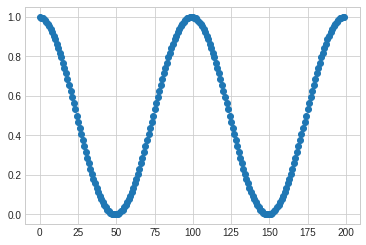

In [ ]:
# A single qubit circuit
a = cirq.NamedQubit('a')

# there are 200 Moments in this circuit. Each is a simulation step.
steps = 200
small_rotations = [cirq.Rx(np.pi / 50.0)(a) for theta in range(steps)]
circuit = cirq.Circuit(small_rotations)

print('Circuit is a bunch of small rotations about Pauli X axis:')
print('{}\n'.format(circuit))

# we are storing here the indices on the X axis
z = []
# we are storing here the probabilities on the Y axis
p0 = []

print('We step through the circuit and plot the z component of the vector '
      'as a function of index of the moment being stepped over.')

simulator = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    # probability is square of amplitude
    prob = np.abs(step.state_vector()) ** 2
    # save the index
    z.append(i)
    # save the probability
    p0.append(prob[0])

# plots a graph
plt.pyplot.style.use('seaborn-whitegrid');
plt.pyplot.plot(z, p0, 'o');

**Above** we have given ourselves direct access to the wave function and calculated the exact probabilities.  Suppose we wanted to sample from the wave function at each point instead.


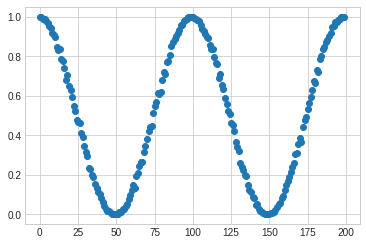

In [ ]:
# A single qubit circuit
a = cirq.NamedQubit('a')

# there are 200 Moments in this circuit. Each is a simulation step.
steps = 200
small_rotations = [cirq.Rx(np.pi / 50.0)(a) for theta in range(steps)]
circuit = cirq.Circuit(small_rotations)

# we are storing here the indices on the X axis
z = []
# we are storing here the probabilities on the Y axis
p0 = []

# Sampling repetitions
repetitions = 1000

simulator = cirq.Simulator()
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    samples = step.sample([a], repetitions=repetitions)
    # 0 is False, 1 is True
    prob = np.sum(samples, axis=0)
    # 1- (the sum of 0 divided by repetitions)
    prob0 = 1 - (prob[0] / repetitions)
    
    # save the index
    z.append(i)
    # save the probability
    p0.append(prob0)
    
plt.pyplot.style.use('seaborn-whitegrid');
plt.pyplot.plot(z, p0, 'o');

## Custom Gate Implementation

Supose there is a gate that you want Cirq to support, but it is not implemented in Cirq.  How do you go about adding a new gate? Cirq tries to be Pythonic.  One way in which it does this is that it relies on Python's **[protocol](https://www.python.org/dev/peps/pep-0544/#defining-a-protocol)** pattern. 

**Note**: Protocols are similar to interfaces, in that they define a collection of methods that an object must support to implement a protocol, but different in that this requirement is more informal and not a part of a class or interface declaration.  An object supports a protocol if it implements the methods that the protocol defines.  You're probably familiar with this if you've ever done something like defined your own `Container` in Python.  To do this for an object you simply define the `__contains__`, `__setitem__`, and `__getitem__` methods on your object, and then you can use this object anywere the Container protocol is supported.  

**Example**:  The gate we will define is a single qubit gate that has only rational amplitudes. This is based on the famous 3, 4, 5 triangle you may remember from a long ago math class: $3^2 + 4^2 = 5^2$.  Using this observation we can construct normalized vectors and a unitary transform using on ratios of $3$, $4$, and $5$: 
$$
\zeta =\left[ \begin{array}
~\frac{3}{5} & \frac{4}{5} \\
-\frac{4}{5} & \frac{3}{5}
\end{array} \right]
$$

Here is a simple implementation of this gate.  To do this we simply define a class that inherits from [`cirq.SingleQubitGate`](https://cirq.readthedocs.io/en/stable/generated/cirq.SingleQubitGate.html#cirq.SingleQubitGate) and implements the [`cirq.SupportsUnitary`](https://cirq.readthedocs.io/en/stable/generated/cirq.SupportsUnitary.html#cirq.SupportsUnitary) protocol by implementing the `_unitary_(self)` method. 

**We will also define a `__str__` representation. By default Cirq will use this string when priting out the gate in a circuit diagram.**

In [ ]:
class RationalGate(cirq.SingleQubitGate):
    
    def _unitary_(self):
        return np.array([[3 / 5, 4 / 5], [-4 / 5, 3 / 5]])
    
    def __str__(self):
        return 'ζ'


a = cirq.NamedQubit('a')
rg = RationalGate()

print(cirq.Circuit([rg(a)]))

a: ───ζ───



**Implemeting `_unitary_` allows cirq to call `cirq.unitary` on an object.**
Almost all of the basic gates we have defined in Cirq have this method implemented.


**Note**: TL;DR if you need to get performant multiqubit gates you should implement a custom `_apply_unitary_to_tensor_`. There is actually an interesting advanced subtly here, which is that many methods in Cirq that ostensibly depend on a gate's unitary try to avoid the `_unitary_` method, because it is extremely inefficient for gates over many qubits. In most cases the method `_apply_unitary_to_tensor_` will be used instead, if it is available. This method allows much more fine grained control on how a unitary is applied to a state, but it is harder to implement as it is expected to e.g. use the pre-allocated workspace buffer that was given to it.


In [ ]:
print(cirq.unitary(rg))

[[ 0.6  0.8]
 [-0.8  0.6]]


## Exercise: Custom Controlled Rx gate

Recall that the `cirq.Rx` gate is a rotation about the $X$ pauli axis:
$$ 
{\tt cirq.Rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] \\
$$ 

### Problem Statement
As an exercise, create a two qubit controlled `cirq.Rx` gate:

$$
{\tt CRx(\theta)}:
\left[\begin{array}
~1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0  \\
0 & 0 & \cos \theta & -i \sin \theta \\
0 & 0 & -i \sin \theta & \cos \theta
\end{array} \right]
$$

In [ ]:
class CRx(cirq.TwoQubitGate):

    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
      return np.array([
        
      ])
    
    # Get this to print nicely in an ASCII circuit, you should also
    # implement the _circuit_diagram_info_ method from the
    # SupportsCircuitDiagramInfo protocol. You can return a tuple
    # of strings from this method.
    def _circuit_diagram_info_(self, args):
      return "@","2"
      #pass


print(np.around(cirq.unitary(CRx(0.25 * np.pi))))     

[]


In [ ]:
# Also get your class to print a circuit correctly.

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
op = CRx(0.25 * np.pi)(a, b)

print(cirq.Circuit([op]))

a: ───@───
      │
b: ───2───


### Solution

In [ ]:
class CRxBootcamp(cirq.TwoQubitGate):

    def __init__(self, theta):
        self.theta = theta

        self.isintheta = -1j * np.sin(self.theta)
        self.costheta = np.cos(self.theta)
      

    def _unitary_(self):
      
      print("the rotation angle is:", self.theta)
      
      return np.array([
          [1, 0, 0,               0],
          [0, 1, 0,               0],
          [0, 0, self.costheta,   self.isintheta],
          [0, 0, self.isintheta,  self.costheta]
      ])
    
    def _circuit_diagram_info_(self, args):
        # the @ is for control
        return '@', 'Rx({}π)'.format(self.theta / np.pi)
          # return "C1", "D2"
    

print('cirq.unitary on the gate yields:')
print(cirq.unitary(CRxBootcamp(0.25 * np.pi)))
print()

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
op = CRxBootcamp(0.25 * np.pi)(a, b)
print('Circuit diagram:')
print(cirq.Circuit([op]))

cirq.unitary on the gate yields:
the rotation angle is: 0.7853981633974483
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.j
  0.        -0.70710678j]
 [0.        +0.j         0.        +0.j         0.        -0.70710678j
  0.70710678+0.j        ]]

Circuit diagram:
a: ───@───────────
      │
b: ───Rx(0.25π)───


## Gate decompositions

In many context, the notion of what gate you can apply is defined either by the physical hardware (e.g. a Device) you are running or perhaps on the quantum error correcting code you are working with.

In quantum computing we typically talk about **gate sets** and work with respect to a given gate set.  Cirq supports gate decomposition via the [`decompose`](https://cirq.readthedocs.io/en/stable/generated/cirq.decompose.html) protocol.  Below we show how one can construct a gate that can be decomposed into two gates.

In [ ]:
class HXGate(cirq.SingleQubitGate):
    
    def _decompose_(self, qubits):
        return cirq.H(*qubits), cirq.X(*qubits)
    
    def __str__(self):
        return 'HX'
    
HX = HXGate()

a = cirq.NamedQubit('a')
circuit = cirq.Circuit([HX(a)])
print("before decomposition:")
print(circuit)

print()

print("after decomposition")
print(cirq.Circuit(cirq.decompose(circuit)))

before decomposition:
a: ───HX───

after decomposition
a: ───Y^0.5───X───X───


Note that this not only decomposed the `HX` gate into `H` and `X`, it also decomposed `H` into `Y**0.5` and `X`.  In order to decompose only once, one can use [`cirq.decompose_once`](https://cirq.readthedocs.io/en/stable/generated/cirq.decompose_once.html):

In [ ]:
print(cirq.Circuit(cirq.decompose_once(HX(a))))

a: ───H───X───


When we define a gate, it is good practice to give a default decompose in terms of gates in `common_gates`.  However often you will want to change this decomposition at run time for the specific hardware or context you are working in.  To do this we can define an interceptor function which does this decomposition before falling back to the default.

In [ ]:
def my_decompose(op):
    if isinstance(op, cirq.GateOperation) and isinstance(op.gate, HXGate):
        return cirq.Z(*op.qubits), cirq.H(*op.qubits)

cirq.Circuit(cirq.decompose(HX(a), intercepting_decomposer=my_decompose))

1 2 3


a: ───Z───Y^0.5───X───

You can also define a predicate that says which gates to keep without decomposing further.
The default predicate is to only keep gates that cannot be decomposed.

In [ ]:
def keep_h_and_x(op):
    return isinstance(op, cirq.GateOperation) and op.gate in [cirq.H, cirq.X]

print(cirq.decompose(HX(a), keep=keep_h_and_x))

[cirq.H.on(cirq.NamedQubit('a')), cirq.X.on(cirq.NamedQubit('a'))]


# Google's Xmon Gates

Google has a class of superconducting qubit devices useful for exploring NISQ algorithms. Cirq was built because it was important that hardware details flow up through the level of abstractions in a framework for NISQ algorithms.

What sort of gates does the Xmon architecture support?  At the hardware level the basic gate set is rotations about the Pauli $Z$ axis
$$\exp(-iZt) = \left[ 
\begin{array}
e^{it} & 0 \\
0 & e^{-it}
\end{array}
\right]$$
Rotations about any axis in the Pauli $X$ and $Y$ plane:
$$\exp(-i(\cos \theta X + \sin \theta Y) t) = 
\left[
\begin{array}
\cos t & -i\sin t e^{-i \theta} \\
-i\sin t e^{i \theta} & \cos t
\end{array}
\right]
$$
The two qubit gate is a phase about the $|11\rangle$ state:
$$
\exp(-it |11\rangle \langle 11|) =
\left[ 
\begin{array}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp(-it)
\end{array}
\right]
$$
And finally a measurement in the computational basis.

Many of the common gates in Cirq are directly accessible on this hardware.

To check whether a gate type is in the Xmon gate set, one can use [`is_native_xmon_op`](https://cirq.readthedocs.io/en/stable/generated/cirq.google.is_native_xmon_op.html).

In [ ]:
cirq.google.is_native_xmon_op(cirq.X.on(cirq.NamedQubit('a')))

True

In [ ]:
cirq.google.is_native_xmon_op(cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')))

False

When a gate is not a native xmon gate, [Cirq can often convert it to an xmon native gate](https://cirq.readthedocs.io/en/stable/generated/cirq.google.ConvertToXmonGates.html?highlight=converttoxmongates);

In [ ]:
# The converter
converter = cirq.google.ConvertToXmonGates()

# Convert a circuit
converted = converter.convert(cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')))

# Print
print(cirq.Circuit(converted))

a: ───Z^0.75────X^0.5────S^-1───Y^-0.5───@───S^-1───Y^0.5───Y^0.5─────Z^-0.75───
                                         │
b: ───X^-0.25───Y^-0.5───────────────────@───S^-1───Y^0.5───X^-0.25─────────────


This isn't very optimized because what it has done is first rely on the decompose of `CNOT` and then decomposed each of these into native xmon gates.  There are many tricks that one can use to simplify xmon gates.  To apply many of these one can use the `cirq.google.optimize_from_xmon` method:

In [ ]:
circuit = cirq.Circuit([cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b'))])

print(cirq.google.optimized_for_xmon(circuit))

a: ───────────────────@──────────────────
                      │
b: ───PhX(-0.5)^0.5───@───PhX(0.5)^0.5───


Because Xmon gates can be executed on Google hardware, they will need to be transmitted as machine code to the quantum computer.  **This means that they have a serialized form**.  We use protobuffers as the serialization.  To see what this form looks like use `cirq.google.gate_to_proto_dict`:

In [ ]:
cirq.google.gate_to_proto_dict(cirq.X, [cirq.GridQubit(5, 5)])

{'exp_w': {'axis_half_turns': {'raw': 0.0},
  'half_turns': {'raw': 1.0},
  'target': {'col': 5, 'row': 5}}}

# Simulations of a Circuit

Now that you know how to construct a `Circuit` in Cirq, let's use Cirq to simulate the circuit.

Here is a simple circuit

In [ ]:
# This circuits is written like a generator
# Gates are not added to a collection,
# but returned iteratively using keyword yield
def basic_circuit(measure=True):
  # The square root of the Pauli X gate
  sqrt_x = cirq.X**0.5
  # The C-Z gate
  cz = cirq.CZ
  
  yield sqrt_x(a), sqrt_x(b)
  yield cz(a, b)
  yield sqrt_x(a), sqrt_x(b)
  
  if measure:
    yield cirq.measure(a, b)
#     yield cirq.measure(b,a)

circuit = cirq.Circuit(basic_circuit())
print(circuit)

a: ───X^0.5───@───X^0.5───M───
              │           │
b: ───X^0.5───@───X^0.5───M───


There are a few things to note here.  

One is that we have used a Python *generator*. Recall that in Python functions that have a `yield` are *generators*. Generators are functions that act as *iterators*. Above we see that we can iterate over ``basic_circuit()``. We see that when we do this each of the `yields` produces what was yielded, and here these are `Operations`,
or lists of ``Operations``. But when we pass this iterator to the append method, something magical happens. `Circuit` is able to flatten all of these an pass them as one giant list to `Circuit.append` (this also works for `Circuit.insert`).
> The above idea uses a concept we call an ``OP_TREE``. An ``OP_TREE`` is
> not a class, but a contract. The basic idea is that, if the input can be
> iteratively flattened into a list of operations, then the input is an
> ``OP_TREE``.
>For example:
>- An Operation is an OP_TREE all by itself.
>- A list of operations is an OP_TREE.
>- A list of tuples of operations is an OP_TREE.
>- A list with a mix of operations and lists of operations is an OP_TREE.
>- A generator yielding operations is an OP_TREE.

A very nice pattern emerges from this structure: define *generators* for sub-circuits, which can vary by size
or `Operation` parameters.

Now we can [simulate](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.html) this circuit.

In [ ]:
simulator = cirq.Simulator()
circuit = cirq.Circuit(basic_circuit())

# First option: sample from the circuit
result = simulator.run(circuit)

print('Measurement results')
print(result)

Measurement results
a,b=0, 0


Running this multiple times should result in different measurement results, since the above circuit produces a superposition over all computational basis states.   

* Above we used the[ `run`](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.run.html) method on the simulator.  These methods mimic the actual hardware in that they **don't give one access to unphysical objects like the wavefunction**. 

* If one wants to **get the wave function**, then the [`simulate`](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.simulate.html) methods can do this:


In [ ]:
circuit = cirq.Circuit()
circuit.append(basic_circuit(measure=False))

# Second option: get the wavefunction
result = simulator.simulate(circuit, qubit_order=[a, b])

print('Wavefunction:')
print(np.around(result.final_state, 3))
print('Dirac notation:')
print(result.dirac_notation())

Wavefunction:
[0.5+0.j  0. +0.5j 0. +0.5j 0.5+0.j ]
Dirac notation:
0.5|00⟩ + 0.5j|01⟩ + 0.5j|10⟩ + 0.5|11⟩


**Note**: We passed a `qubit_orde`r into the `simulate` method.  This order helps define the order of the kronecker product used in the resulting `final_state` vector. 


The `qubit_order` argument is optional. When it is omitted, qubits are sorted ascending according to the ordering methods defined by their Python class (for example `cirq.NamedQubit` sorts lexicographically by name).
If there are multiple types of qubits in one circuit, the name of the type is used as a tie breaker.

The simplest `qubit_order` value you can provide is a list of the qubits in the desired order. Any qubits from the circuit that are not in the list will be ordered using the  default `__str__` ordering, but come after qubits that are in the list.

**Note**: All qubits of a circuit definition are included in the simulation, even if they are not operated on by the circuit.

The mapping from the order of the qubits to the order of the  amplitudes in the wave function can be tricky to understand.  Basically, it is the same as the ordering used by `numpy.kron`.

> If wave function is array 
>>(0.1, 0.2, 0.3, 0.4)

> then this is 
>> 0.1|00⟩ + 0.2|01⟩ + 0.3|10⟩ + 0.4|11⟩ 

>in Dirac notation.  If the 
>> qubit order = [a, b]

>then |00> means qubit a is in 0 and qubit b is in 0, |01> means 
> qubit a is 0 and qubit b is 1, etc.

Another way to think about the qubit-to-amplitude ordering is as "for loop ordering":

```
for a in [0, 1]:
    for b in [0, 1]:
        print(a, b)
```

The first index (the outermost loop) is the slowest to vary.

## Repetitions

The simulator `run` methods also take an option for repeating the circuit. If the measurements in the circuit are terminal, and all other operations are unitary, this simulator is optimized to not recompute the wavefunction before sampling from the circuit.  So for example this code doesn't recompute the wave function but knows to sample from the final measurements

In [ ]:
circuit = cirq.Circuit(basic_circuit())

# Specify a number (e.g. 1000) of repetitions
nr_repetitions = 1000
result = simulator.run(circuit, repetitions=nr_repetitions)

# The measurement was on qubits "a,b".
# See definition of basic_circuit at measurement
# Therefore, key is "a,b"
# If the measurement would habe been, for example, "b,a" then key='b,a'
print(repr(result)) 
# to see internal structure of TrialResult

# Print the histogram using key='a,b'
print(result.histogram(key='a,b'))


cirq.TrialResult(params=cirq.ParamResolver({}), measurements={'a,b': np.array([[0, 0], [0, 1], [0, 0], [1, 0], [1, 0], [1, 0], [0, 0], [1, 0], [1, 1], [1, 1], [1, 1], [0, 1], [1, 0], [0, 0], [0, 0], [1, 0], [1, 0], [0, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 1], [0, 1], [1, 0], [0, 0], [1, 0], [0, 1], [0, 1], [0, 0], [0, 1], [0, 0], [0, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 1], [1, 0], [0, 0], [0, 1], [0, 0], [1, 1], [1, 0], [0, 1], [0, 1], [1, 1], [1, 1], [0, 1], [1, 1], [1, 0], [0, 1], [1, 0], [1, 1], [0, 1], [0, 0], [0, 0], [0, 0], [1, 1], [0, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 1], [0, 0], [1, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 1], [0, 1], [0, 0], [0, 1], [0, 0], [0, 1], [0, 1], [1, 1], [0, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 0], [1, 1], [1, 1], [1, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 1], [1, 0], [0, 0], [0, 1], [1, 1], [1, 0], [1, 1], [0, 0], [1, 1], [1, 0], [1, 0], [

Here we have also demonstrated the use of the [`histogram`](https://cirq.readthedocs.io/en/stable/generated/cirq.TrialResult.histogram.html) method on the `result`. The `histogram` sums over all the different results for all of the different repetitions, and can also be given a `fold_func` argument, in order to group measurement results under some key before counting them up.

**Example**: We can group by whether or not the two measurement results agreed:

In [ ]:
# a lambda (anonymous function) is used
print(result.histogram(key='a,b', fold_func=lambda e: 'agree' if e[0] == e[1] else 'disagree'))

# the same without lambda
def count_results(e):
  if e[0] == e[1]:
    return 'agree'
  else:
    return 'disagree'
  
# The same output like from the previous print statement
print(result.histogram(key='a,b', fold_func=count_results))

Counter({'agree': 503, 'disagree': 497})
Counter({'agree': 503, 'disagree': 497})


# Parameterized Circuits

In addition to circuit gates with fixed values, Cirq also supports parameterized gates with symbolic values via [`sympy`](https://www.sympy.org/en/index.html). These are placeholder values, such as `sympy.Symbol('x')`, that will only be resolved at *run-time*. For simulators these values are resolved by providing a [`ParamResolver`](https://cirq.readthedocs.io/en/stable/generated/cirq.ParamResolver.html).  A `ParamResolver` provides a map from the `Symbol`'s name to its assigned value. 

**Note**: Plain Python dictionaries can be used whenever a `ParamResolver` is needed.

In [ ]:
import sympy as sp

a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
simulator = cirq.Simulator()

# a sympy Symbol
val = sp.Symbol('s')
# the symbol is used in a sympy expression
pow_x_gate = cirq.X**val

# the circuit will consist of two parameterized gates
circuit = cirq.Circuit()
circuit.append([pow_x_gate(a), pow_x_gate(b)])

print('Circuit with parameterized gates -- the symbol is "s"')
print(circuit)
print()

for y in range(5):
    # create a dictionary to be used in the simulator
    the_dictionary = {'s': y / 4.0}
    #
    result = simulator.simulate(circuit, param_resolver=the_dictionary)
    # print(repr(result))
    #
    print('s={}: {}'.format(y, np.around(result.final_state, 2)))

Circuit with parameterized gates -- the symbol is "s"
a: ───X^s───

b: ───X^s───

s=0: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
s=1: [ 0.6 +0.6j   0.25-0.25j  0.25-0.25j -0.1 -0.1j ]
s=2: [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
s=3: [-0.1 +0.1j   0.25+0.25j  0.25+0.25j  0.6 -0.6j ]
s=4: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


Here we see that the `Symbol` is used in two gates, and then the resolver provides this value at run time.

Parameterized values are most useful in defining what we call a `Study`. 

**A `Study`** is a collection of trials, where each  trial is a run with a particular set of configurations and which may be run repeatedly. [ Running a study](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.run_sweep.html) returns a list of `TrialResult`s per set of fixed parameter values and repetitions.

**Example**:


In [ ]:
# Create a list of paramresolvers
resolvers = [cirq.ParamResolver({'s': y / 8.0}) for y in range(9)]

# The circuit to be used in the study uses gates which are parameterized
# with sympy Symbols -> see in previous cell the definition of pow_x_gate
circuit = cirq.Circuit()
circuit.append([pow_x_gate(a), pow_x_gate(b)])
circuit.append([cirq.measure(a), cirq.measure(b)])

results = simulator.run_sweep(program=circuit,
                              params=resolvers,
                              repetitions=200)
for i, result in enumerate(results):
    print('params: {}\n{}'.format(result.params.param_dict, result))

params: {'s': 0.0}
a=00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
b=00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
params: {'s': 0.125}
a=00000000000000000001000000000000000000001000010000000000000000000000000000000000000000000000000010001000001001000000000000000000000001001000000000000000000000000000000000000000000000000000000000000000
b=01000000000000000000000000000000100000010010000000000000000100000000000000000000000000000000000000000000000010000000000000000000000001001000001000000000001000000000000000000000000000100010000000000000
params: {'s': 0.25}
a=000010000000000000000000010000000000100100000000000000100000000000000001000100100000000000000000110000011010010000000000000100

Above we passed in a list of `ParamResolver`s to the `params` parameter of [`run_sweep`](https://cirq.readthedocs.io/en/stable/generated/cirq.Simulator.run_sweep.html).  But one can also pass in a [`Sweepable`](https://cirq.readthedocs.io/en/stable/generated/cirq.Sweepable.html?highlight=sweepable).  There are some useful methods for generating `Sweepable`s, for example to generate an equally spaced set of param resolvers one can use [`Linspace`](https://cirq.readthedocs.io/en/stable/generated/cirq.Linspace.html)


In [ ]:
linspace = cirq.Linspace(start=0, stop=1.0, length=11, key='x')
for p in linspace:
    print(p)

cirq.ParamResolver(OrderedDict([('x', 0.0)]))
cirq.ParamResolver(OrderedDict([('x', 0.1)]))
cirq.ParamResolver(OrderedDict([('x', 0.2)]))
cirq.ParamResolver(OrderedDict([('x', 0.3)]))
cirq.ParamResolver(OrderedDict([('x', 0.4)]))
cirq.ParamResolver(OrderedDict([('x', 0.5)]))
cirq.ParamResolver(OrderedDict([('x', 0.6)]))
cirq.ParamResolver(OrderedDict([('x', 0.7)]))
cirq.ParamResolver(OrderedDict([('x', 0.8)]))
cirq.ParamResolver(OrderedDict([('x', 0.9)]))
cirq.ParamResolver(OrderedDict([('x', 1.0)]))


## Exercise: Rotate a qubit

Let's do the equivalent of a Rabi-flop experiment.  That is lets apply an `PowXGate` rotating about the `X` axis for a linearly spaced set of values followed by a computational basis measurement.  The end result should be a plot of the sampled fraction that were $|1\rangle$ as a function of gates of $X^t$ for $t$ between 0 and $1$ for 100 values of $t$ and each result sampled 100 times.

You can use matplotlib to plot this, see example plot code below.

Example plot of two collections: one for horizontal axis, the other for vertical axis


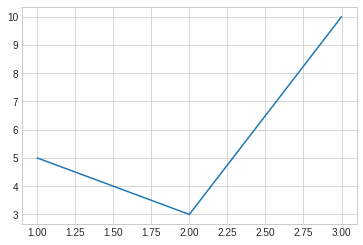

In [ ]:
print("Example plot of two collections: one for horizontal axis, the other for vertical axis")
plt.pyplot.plot([1, 2, 3], [5, 3, 10]);

In [ ]:
import sympy as sp

a = cirq.NamedQubit('a')

# the symbol
val = sp.Symbol('s')

# the gate - where val is symbol
pow_x_gate=cirq.X**val


# the circuit is a single qubit one
circuit = cirq.Circuit()
#apply the gate to qubit a
circuit.append([pow_x_gate(a)])
# measure qubit a
circuit.append([cirq.measure(a)])

# nr points in the space
nr_points = 100

# the resolver
resolvers = [cirq.ParamResolver({'s': y / nr_points}) for y in range(nr_points)]

# sampled 100 times = 100 repetitions
results = simulator.run_sweep(program=circuit,
                              params=resolvers,
                              repetitions=100)
# all the results
# print(results)

# the length of the results should be nr_points
# print(len(results))

###Solution

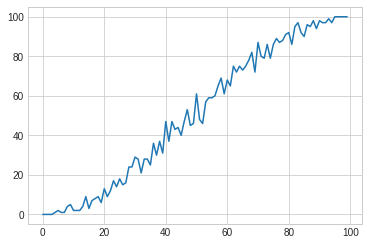

In [ ]:
# histogram according to key "a", because qubit "a" was measured
h_axis = []
v_axis = []
for i in range(nr_points):
  # compute histogram
  hres = results[i].histogram(key='a')
  
  # store 
  h_axis.append(i)
  # store the histogram value for key 1
  v_axis.append(hres[1])

plt.pyplot.plot(h_axis, v_axis);


# Noise

In addition to circuits with unitary gates, Cirq also has support for modeling noisy quantum evolutions. This is useful when modeling what will happen when running on actual hardware. Cirq currently supports noise that fits within the context of *operator sum representations* of noise (a.k.a quantum operations, quantum dynamical maps, superoperators, etc).  This formalism models the evolution of a density matrix via 
$$\rho \rightarrow \sum_k A_k \rho A_k^\dagger$$
where the $A_k$ are *Krauss operators*.  These operators are not necessarily unitary and satisfy the property
$$ \sum_k A_k^\dagger A_k = I$$

**Example**: a noise operator is the depolarizing channel on one qubit.  This takes
$$\rho \rightarrow (1-p) \rho + \frac{p}{3} (X \rho X + Y \rho Y + Z \rho Z)$$
In Cirq we can define such a [depolarizing channel](https://cirq.readthedocs.io/en/stable/generated/cirq.depolarize.html) and use it in a quantum circuit:

In [ ]:
circuit = cirq.Circuit(cirq.depolarize(0.2)(a), cirq.measure(a))
print(circuit)

a: ───D(0.2)───M───


Previously we saw that gates could implement that `_unitary_` protocol, and by doing so they could be used to perform wave function simulation.  For noise the gates implement the `_channel_` protocol.  [Classes that implement this protocol](https://cirq.readthedocs.io/en/stable/noise.html) return the Krauss operators on their `_channel_` method.  Thus

In [ ]:
for i, krauss in enumerate(cirq.channel(cirq.depolarize(0.2))):
    print('{}th krauss operator is {}'.format(i, krauss))
print()

for i, krauss in enumerate(cirq.channel(cirq.depolarize(0.2))):
    pauli_ex = cirq.expand_matrix_in_orthogonal_basis(krauss, cirq.PAULI_BASIS)
    print('{}th krauss operator is {}'.format(i, pauli_ex))

0th krauss operator is [[0.89442719 0.        ]
 [0.         0.89442719]]
1th krauss operator is [[0.        +0.j 0.25819889+0.j]
 [0.25819889+0.j 0.        +0.j]]
2th krauss operator is [[0.+0.j         0.-0.25819889j]
 [0.+0.25819889j 0.+0.j        ]]
3th krauss operator is [[ 0.25819889+0.j  0.        +0.j]
 [ 0.        +0.j -0.25819889+0.j]]

0th krauss operator is 0.8944271909999159*I
1th krauss operator is 0.2581988897471611*X
2th krauss operator is 0.2581988897471611*Y
3th krauss operator is 0.2581988897471611*Z


In addition to the wave function simulator, Cirq also has a [density matrix simulator](https://cirq.readthedocs.io/en/stable/generated/cirq.DensityMatrixSimulator.html?highlight=densitymatrixsimulator).  Instead of keeping track of the wave function this simulator keeps track of the density matrix.  It has the same `run` and `simulate` type methods.  

**Example**: Use this simulator to simulate a depolarizing channel and return the final density matrix of the system

In [ ]:
# The depolarizing channel
circuit = cirq.Circuit(cirq.depolarize(0.2)(a))
print('Circuit:\n{}\n'.format(circuit))

# The density matrix simulator, used when expressing noise by Krauss operators
simulator = cirq.DensityMatrixSimulator()

# The simulation result is a matrix
matrix = simulator.simulate(circuit).final_density_matrix

# Print
print('Final density matrix:\n{}'.format(matrix))

Circuit:
a: ───D(0.2)───

Final density matrix:
[[0.8666666 +0.j 0.        +0.j]
 [0.        +0.j 0.13333333+0.j]]


**Note**: The density matrix simulator simulates measurement statistically, and not as a channel where the outcome is not known.  Thus for example 

In [ ]:
circuit = cirq.Circuit(cirq.depolarize(0.2)(a), cirq.measure(a))
simulator = cirq.DensityMatrixSimulator()
for _ in range(5):
    print(simulator.simulate(circuit).final_density_matrix)
    print()

[[0.       +0.j 0.       +0.j]
 [0.       +0.j 0.9999999+0.j]]

[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]

[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]

[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]

[[0.99999994+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j]]



## Monte Carlo Simulations

Density matrix simulations are more expensive than pure state wave function simulations.  However some channels allow an interpretation of randomly applying one of a fixed set of unitaries with differing probabilites.  

**Example**: The depolarizing channel above can be interpretted as: with probability $1-p$ apply the identity to the state and with probability $p$ apply one of the three Pauli matrices $X$, $Y$, or $Z$ with equal probability. 

Channels that can be interpretted in this form can be simulated using a wave function simulator: when this channel is simulated the simulation will sample a unitary with the appropriate probability. For channels of these type, the channel can, instead of implementing the `_channel_` protocol, implement the [`_mixture_`](https://cirq.readthedocs.io/en/stable/generated/cirq.mixture.html) protocol:

In [ ]:
prob = 0.4

# Identity should have 1-prob, e.g. 0.8
# X should have prob/3, e.g. 0.06666666666666667
# Y should have prob/3, e.g. 0.06666666666666667
# Z should have prob/3, e.g. 0.06666666666666667
for p, u in cirq.mixture(cirq.depolarize(prob)):
    print('prob={}\nunitary\n{}\n'.format(p, u))

prob=0.6
unitary
[[1. 0.]
 [0. 1.]]

prob=0.13333333333333333
unitary
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

prob=0.13333333333333333
unitary
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

prob=0.13333333333333333
unitary
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]



In fact the depolarizing channel does not implement `_channel_`.  Instead it only implements `_mixture_` and the `cirq.channel` method notices this and derives the channel from the mixture.

In [ ]:
d = cirq.depolarize(0.2)
print('does cirq.depolarize(0.2) have _channel_? {}'.format('yes' if getattr(d, '_channel_', None) else 'no'))
print('does cirq.depolarize(0.2) have _mixture_? {}'.format('yes' if getattr(d, '_mixture_', None) else 'no'))

does cirq.depolarize(0.2) have _channel_? no
does cirq.depolarize(0.2) have _mixture_? yes


When channels implement mixture then, as we said, we can use the wave function simulator:

In [ ]:
circuit = cirq.Circuit(cirq.depolarize(0.5).on(a), cirq.measure(a))

# The wave function simulator
simulator = cirq.Simulator()

# This is a TrialResult
result = simulator.run(circuit, repetitions=10)

print("run {} repetitions and get something different each time: {}".format(result.repetitions, result))

run 10 repetitions and get something different each time: a=0001000000


## Adding Noise to Circuits and Simulations

To add noise to circuits or during simulations, we provide the notion of a `NoiseModel`.  A `NoiseModel` may add noise operation by operation, or it may add noise moment by moment, or it may add noise across a list of moments.

**Example**: define a noise model that add a single qubit depolarizing for every qubit in each moment.  

In [ ]:
noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(0.2))

circuit = cirq.Circuit([cirq.H(a), cirq.CNOT(a, b), cirq.measure(a, b)])
print('Circuit with no noise:\n{}\n'.format(circuit))

# Sort the qubits
system_qubits = sorted(circuit.all_qubits())

# The new circuit is noisy
noisy_circuit = cirq.Circuit()
# Take each moment of the original circuit
for moment in circuit:
    # Add the noise to each qubit of each moment
    noisy_circuit.append(noise.noisy_moment(moment, system_qubits))
    
print('Circuit with noise:\n{}'.format(noisy_circuit))


Circuit with no noise:
a: ───H───@───M───
          │   │
b: ───────X───M───

Circuit with noise:
a: ───H───D(0.2)───@───D(0.2)───M───D(0.2)───
                   │            │
b: ───────D(0.2)───X───D(0.2)───M───D(0.2)───


In [ ]:
# Add the noise to the density matrix simulator
simulator = cirq.DensityMatrixSimulator(noise=noise)

# Simulate the not-noisy circuit with noise
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    print('* After step {} state was\n{}\n'.format(i, step.density_matrix()))
    
#
# The noisy circuit without noise in the density matrix simulator
#
# Add the noise to the density matrix simulator
simulator = cirq.DensityMatrixSimulator()
    
# Simulate the not-noisy circuit with noise
for i, step in enumerate(simulator.simulate_moment_steps(noisy_circuit)):
    print('+ After step {} state was\n{}\n'.format(i, step.density_matrix()))

* After step 0 state was
[[0.4333333 +0.j 0.        +0.j 0.31777775+0.j 0.        +0.j]
 [0.        +0.j 0.06666666+0.j 0.        +0.j 0.04888888+0.j]
 [0.31777775+0.j 0.        +0.j 0.4333333 +0.j 0.        +0.j]
 [0.        +0.j 0.04888888+0.j 0.        +0.j 0.06666666+0.j]]

* After step 1 state was
[[0.34859255+0.j 0.        +0.j 0.        +0.j 0.17089382+0.j]
 [0.        +0.j 0.15140739+0.j 0.02629136+0.j 0.        +0.j]
 [0.        +0.j 0.02629136+0.j 0.15140739+0.j 0.        +0.j]
 [0.17089382+0.j 0.        +0.j 0.        +0.j 0.34859255+0.j]]

* After step 2 state was
[[0.75111103+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.11555554+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.11555553+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.01777777+0.j]]

+ After step 0 state was
[[ 0.49999997-0.j  0.        -0.j  0.49999997-0.j -0.        -0.j]
 [ 0.        -0.j  0.        -0.j -0.        -0.j -0.        -0.j]
 [ 0

# Compiling / Optimizing

Cirq's philosophy for what are often called compilation steps is slightly non-traditional.  In particular, we believe that NISQ devices perform so few gates that many compilations will be one or a few passes. A useful class of optimization code for this is the [`PointOptimizer`](https://cirq.readthedocs.io/en/stable/generated/cirq.PointOptimizer.html).

**Example**: Here is a `PointOptimizer` that recognizes that a `X` gate followed by a `Z` gate is equivalent to a `Y` gate

In [ ]:
class XZOptimizer(cirq.PointOptimizer):
    """Replaces an X followed by a Z with a Y."""
    
    # The circuit to improve
    # The index of the moment with the operation to focus on
    # The operation to focus improvements upon
    def optimization_at(self, circuit, index, op):
        # Is the gate an X gate?
        if isinstance(op, cirq.GateOperation) and (op.gate == cirq.X):
          
            # Finds the index of the next moment that touches the given qubits.
            next_op_index = circuit.next_moment_operating_on(op.qubits, index + 1)
            qubit = op.qubits[0]
            
            # If the next index exists
            if next_op_index is not None:
              
                # Get the operation at the existing index
                next_op = circuit.operation_at(qubit, next_op_index)
                
                # Is this next_op a Z gate?
                if isinstance(next_op, cirq.GateOperation) and  (next_op.gate == cirq.Z):
                  
                    # If yes, replace the X and the Z with a Y
                    new_op = cirq.Y.on(qubit)
                   
                    # see https://cirq.readthedocs.io/en/stable/generated/cirq.PointOptimizationSummary.html?highlight=pointoptimizationsummary
                    return cirq.PointOptimizationSummary(
                        clear_span = next_op_index - index + 1, # Range of moments to affect. 
                        clear_qubits = op.qubits, # The set of qubits that should be cleared with each affected moment
                        new_operations = [new_op] # The operations to replace
                    )
        return None
                        
        
# The optimizer
opt = XZOptimizer()

a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

# Unoptimized circuit
circuit = cirq.Circuit(cirq.X(a), cirq.Z(a), cirq.Y(a), cirq.CZ(a, b), cirq.X(a), cirq.CNOT(a,c))
print('Before\n{}\n'. format(circuit))

# Optimized circuit
opt.optimize_circuit(circuit)
print('After XZ opt\n{}\n'.format(circuit))

# We can remove the empty moments
remempty = cirq.DropEmptyMoments()
remempty.optimize_circuit(circuit)
print('After Drop opt\n{}\n'.format(circuit))


Before
a: ───X───Z───Y───@───X───@───
                  │       │
b: ───────────────@───────┼───
                          │
c: ───────────────────────X───

After XZ opt
a: ───Y───────Y───@───X───@───
                  │       │
b: ───────────────@───────┼───
                          │
c: ───────────────────────X───

After Drop opt
a: ───Y───Y───@───X───@───
              │       │
b: ───────────@───────┼───
                      │
c: ───────────────────X───



## Exercise: Simplify flipped CNOTs

Write a PointOptimizer that performs (greedily) the simplification that

```
a: ───H───@───H───
          │
b: ───H───X───H───
```
is equal to


```
a: ───X───
      │
b: ───@───
```





### **Solution**:

In [ ]:
class HadamardOptimizer(cirq.PointOptimizer):
    """Replaces an H followed by a H with nothing."""
    
    # The circuit to improve
    # The index of the moment with the operation to focus on
    # The operation to focus improvements upon
    def optimization_at(self, circuit, index, op):
        # Is the gate a Hadamard gate?
        if isinstance(op, cirq.GateOperation) and (op.gate == cirq.H):
          
            # Finds the index of the next moment that touches the given qubits.
            next_op_index = circuit.next_moment_operating_on(op.qubits, index + 1)
            qubit = op.qubits[0]
            
            # If the next index exists
            if next_op_index is not None:
              
                # Get the operation at the existing index
                next_op = circuit.operation_at(qubit, next_op_index)
                
                # Is this next_op another Hadamard gate?
                if isinstance(next_op, cirq.GateOperation) and  (next_op.gate == cirq.H):
                  
                    # see https://cirq.readthedocs.io/en/stable/generated/cirq.PointOptimizationSummary.html?highlight=pointoptimizationsummary
                    return cirq.PointOptimizationSummary(
                        clear_span = next_op_index - index + 1, # Range of moments to affect. 
                        clear_qubits = op.qubits, # The set of qubits that should be cleared with each affected moment
                        new_operations = [ ] # replace with empty
                    )
        return None


hadamard_opt = HadamardOptimizer()

a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

# Unoptimized circuit
circuit = cirq.Circuit([ cirq.Moment([cirq.H(a), cirq.H(b)]),
                         cirq.Moment([cirq.H(b), cirq.H(c)])
                      ])
circuit.append(cirq.T(c))
print('Before optimization\n{}\n'. format(circuit))

# Optimized circuit
hadamard_opt.optimize_circuit(circuit)
print('After H opt\n{}\n'.format(circuit))

Before optimization
a: ───H───────────

b: ───H───H───────

c: ───────H───T───

After H opt
a: ───H───────────

c: ───────H───T───



# Devices

NISQ algorithms work in a regime where every gate counts.  A key philosophy behind Cirq is that we believe the details of the hardware, the performance characteristics, as well as device constraints, will be key to getting the most out of NISQ algorithms.  Towards this end these hardware features are contained in the `Device` class.

**Example**: Here is Google's Bristlecone device

In [ ]:
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

In a future version, we intend for each `Device` to define a noise model.

`Device`s also contain more information about the timing of the device. 

**Example**:  We can calculate the duration of an `Exp11Gate` on the `Bristlecone` device

In [ ]:
brissy = cirq.google.Bristlecone
op = cirq.X.on(cirq.GridQubit(5, 5))
print(brissy.duration_of(op))

20 ns


Another property of devices is that they can be used to enforce constraints from the hardware, both checking that these constraints are satisfied, but also enforcing the constraints on the device.  For example on the `Bristlecone` device a two qubit gate has the property that one cannot simultaneously perform a pair of two qubit gates that act on adjacent qubits. So for example if we create such a `Circuit` and validate it using the device, Cirq will complain.

In [ ]:
q55 = cirq.GridQubit(5, 5)
q56 = cirq.GridQubit(5, 6)
q66 = cirq.GridQubit(6, 6)
q67 = cirq.GridQubit(6, 7)

ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]
circuit = cirq.Circuit(ops)
print(circuit)
print('But when we validate it against the device:')
cirq.google.Bristlecone.validate_circuit(circuit)
# (this should throw an error)

(5, 5): ───@───
           │
(5, 6): ───@───

(6, 6): ───@───
           │
(6, 7): ───@───
But when we validate it against the device:


ValueError: ignored

But more interestingly we could have passed the device into the `Circuit` and it will perform the creation of the circuit (using the insertion semanics as described above) such that the device cannot violate the constraints.

In [ ]:
#these are the gates
ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]

"""
Here is the circuit specifically targetting the device
"""
circuit = cirq.Circuit(device=cirq.google.Bristlecone)

# The gates will be in different moments
circuit.append(ops)

# Let's see
print(circuit)

(5, 5): ───@───────
           │
(5, 6): ───@───────

(6, 6): ───────@───
               │
(6, 7): ───────@───


## Exercise: Make a Device

Construct a device called GenevaDevice that:
* Acts on a square sized lattice
* Only allows Hadamard, CNOT, Rz, and measurement gates
* It should support the decomposition of Toffoli and CZ gates

In [ ]:
# have a look at 
# https://cirq.readthedocs.io/en/stable/schedules.html#devices
# https://cirq.readthedocs.io/en/stable/generated/cirq.GridQubit.html
# https://cirq.readthedocs.io/en/stable/generated/cirq.Duration.html

# your code here

### Solution

In [ ]:
class CirqBootcampDevice(cirq.Device):

  def __init__(self):
      self.qubits = []
      # A grid of qubits with size 3 x 3 ???
      for i in range(3):
        for j in range(3):
          self.qubits.append(cirq.GridQubit(i, j))
    

  def duration_of(self, operation):
      return cirq.Duration(nanos=10)

  def decompose_operation(self, op):
        # TODO: Fill in the solution....
        # Known gate name
        if not isinstance(op, cirq.GateOperation):
            raise TypeError("{!r} is not a gate operation.".format(op))

        if self.is_supported_operation(op):
          return op

        if isinstance(op.gate, (cirq.ops.CCXPowGate)):
          raise TypeError("Decompose the Toffoli for this work!")

  def is_supported_operation(self, op):
    # check if it is an operation
    if not isinstance(op, cirq.GateOperation):
        return False

    # check types
    # Only allows Hadamard, CNOT, Rz, and measurement gates
    to_keep = isinstance(op.gate, (
            cirq.ops.CNotPowGate,
            cirq.ops.ZPowGate,
            cirq.ops.HPowGate,
            cirq.ops.MeasurementGate))
    return to_keep


  def validate_operation(self, operation):
      # check gate types
      if not self.is_supported_operation(operation):
          raise ValueError('{!r} is not a supported gate'.format(operation.gate))
        
      # Check connectivity
      if len(operation.qubits) == 2:
          p, q = operation.qubits
          if not p.is_adjacent(q):
            raise ValueError('Non-local interaction: {}'.format(repr(operation)))


  def validate_scheduled_operation(self, schedule, scheduled_operation):
      self.validate_operation(scheduled_operation.operation)

  def validate_circuit(self, circuit):
      for moment in circuit:
          for operation in moment.operations:
              self.validate_operation(operation)

  def validate_schedule(self, schedule):
      for scheduled_operation in schedule.scheduled_operations:
          self.validate_scheduled_operation(schedule, scheduled_operation)

In [ ]:
gd = CirqBootcampDevice()
print(gd.qubits)

mycircuit = cirq.Circuit(device = gd)

# will work
mycircuit.append(cirq.H(cirq.GridQubit(0,0)))
mycircuit.append(cirq.CNOT(cirq.GridQubit(0,0), cirq.GridQubit(0,1)))
mycircuit.append(cirq.T(cirq.GridQubit(0,0)))

# will fail
# mycircuit.append(cirq.CCX(cirq.GridQubit(0,0), cirq.GridQubit(0,1), cirq.GridQubit(0,2)))

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]


# Other interesting things in Cirq

## Experiments

The `cirq.experiments` package can perform and plot the results of some basic experiments for understanding how well a system is performing.



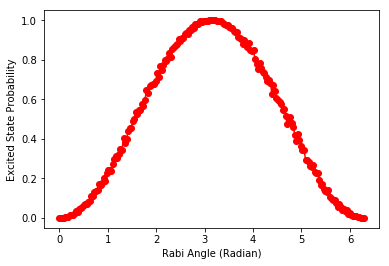

In [ ]:
result = cirq.experiments.rabi_oscillations(
    sampler=cirq.Simulator(),  # In the future, sampler could point at real hardware.
    qubit=cirq.LineQubit(0)
)
result.plot()

##Testing

The `cirq.testing` package has useful debugging and testing methods like `cirq.testing.assert_implements_consistent_protocols` and `cirq.testing.assert_allclose_up_to_global_phase`.


In [ ]:
class InconsistentXGate(cirq.SingleQubitGate):

    def _decompose_(self, qubits):
        yield cirq.H(qubits[0])
        yield cirq.Z(qubits[0])
        yield cirq.H(qubits[0])

    def _unitary_(self):
        return np.array([[0, -1j], [1j, 0]])  # Oops! Y instead of X!

cirq.testing.assert_decompose_is_consistent_with_unitary(InconsistentXGate())

##Export

You can export a circuit as QASM.

In [ ]:
a, b, c = cirq.LineQubit.range(3)
circuit = cirq.Circuit.from_ops(cirq.H(a), cirq.H(c), cirq.CNOT(a, b), cirq.CCZ(a, b, c))
print(circuit.to_qasm())

// Generated from Cirq v0.5.0

OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [0, 1, 2]
qreg q[3];


h q[0];
h q[2];
cx q[0],q[1];
h q[2];
ccx q[0],q[1],q[2];
h q[2];



## Quirk

You can also turn a circuit into a link to the drag-and-drop web simulation Quirk (though somewhat inconveniently).

In [ ]:
from cirq.contrib.quirk.export_to_quirk import circuit_to_quirk_url
print(circuit_to_quirk_url(circuit))

http://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C1%2C%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%5D%7D
